In [1]:
import numpy as np
import pandas as pd

from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler

from sklearn.pipeline import make_pipeline
from sklearn.base import clone

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, SelectPercentile, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier

from sklearn.decomposition import PCA, NMF

from mlens.visualization import pca_plot

trius = np.load('trius.npy')
labels = np.load('labels.npy')
W = np.load('nmf.npy')
P = np.load('pca.npy')
Code = np.load('code.npy')

seed = 2019
np.random.seed(seed)
X = trius
y = labels

X = MinMaxScaler().fit_transform(X)

# 0.03, chi2, 2048, noPCA, RF, 0.885
# 0.03, chi2, 2048, noPCA, GB, 0.923

selector = VarianceThreshold(0.03)
selector.fit(X)
X = selector.transform(X)
print(X.shape)

selector = SelectKBest(chi2, k=2048)
X = selector.fit_transform(X, y)
print(X.shape)

etc = GradientBoostingClassifier().fit(X, y)
model = SelectFromModel(etc, prefit=True)
X = model.transform(X)
print(X.shape)

# X = PCA(n_components=128).fit_transform(X)
# print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
print('样本集大小：',X.shape,y.shape)
print('训练集大小：',x_train.shape,y_train.shape)  # 训练集样本大小
print('测试集大小：',x_test.shape,y_test.shape)  # 测试集样本大小

[MLENS] backend: threading


(252, 3772)
(252, 2048)
(252, 148)
样本集大小： (252, 148) (252,)
训练集大小： (226, 148) (226,)
测试集大小： (26, 148) (26,)


In [6]:
def get_models():
    nb = GaussianNB()
    svc = SVC(kernel='rbf', C=100, gamma=1e-3, probability=True)
    knn = KNeighborsClassifier(n_neighbors=10)
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((64, 16), solver='lbfgs', activation='relu', random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=seed)
    rf = RandomForestClassifier(n_estimators=10, max_features=5, random_state=seed)
    ab = AdaBoostClassifier(random_state=seed)
    
    models = {'svm': svc, 'knn': knn, 'naive bayes': nb,
             'mlp': nn, 'random forest': rf, 'gbm': gb, 'logistic': lr,
             'adaboost': ab,}
    return models


def train_predict(model_list):
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(x_train, y_train)
        P.iloc[:, i] = m.predict_proba(x_test)[:, 1]
        cols.append(name)
        print("done")
    
    P.columns = cols
    print("Done.\n")
    return P

def cross_val_models(model_list, cv=10):
    P = np.zeros((cv, len(model_list)))
    P = pd.DataFrame(P)

    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        P.iloc[:, i] = cross_val_score(m, X, y, cv=cv)
        cols.append(name)
        print("done")
    P.columns = cols
    print('Done.\n')
    return P

def cross_val_acc(P):
    for m in P.columns:
        score = np.mean(P.loc[:, m])
        std = 2 * np.std(P.loc[:, m])
        print('{} ACC Result {} +/- {}'.format(m, score, std))

def score_models(P, y):
    print('ROC AUC SCORE')
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print('ACC SCORE')
    for m in P.columns:
        score = accuracy_score(y, np.float32(P.loc[:, m]>=0.5))
        print("%-26s: %.3f" % (m, score))

In [3]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gbm... done
logistic... done
adaboost... 

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done
Done.

ROC AUC SCORE
svm                       : 0.885
knn                       : 0.839
naive bayes               : 0.806
mlp                       : 0.739
random forest             : 0.873
gbm                       : 0.945
logistic                  : 0.721
adaboost                  : 0.855
ACC SCORE
svm                       : 0.808
knn                       : 0.769
naive bayes               : 0.654
mlp                       : 0.731
random forest             : 0.692
gbm                       : 0.885
logistic                  : 0.731
adaboost                  : 0.731


In [4]:
models = get_models()
cv_results=cross_val_models(models)

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gbm... done
logistic... done
adaboost... 

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logisti

done
Done.



In [7]:
cross_val_acc(cv_results)

svm ACC Result 0.8247307692307692 +/- 0.16934403552196314
knn ACC Result 0.7776282051282051 +/- 0.17522999819735366
naive bayes ACC Result 0.677923076923077 +/- 0.2360884900793111
mlp ACC Result 0.7731666666666667 +/- 0.16067379697240797
random forest ACC Result 0.7419487179487179 +/- 0.1677089617700502
gbm ACC Result 0.8693589743589742 +/- 0.09936425130734808
logistic ACC Result 0.7653205128205128 +/- 0.15925885420596878
adaboost ACC Result 0.7817820512820511 +/- 0.13690091292811846


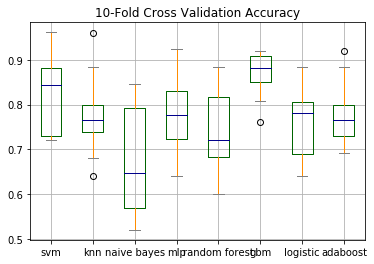

In [5]:
color = dict(boxes='DarkGreen',whiskers='DarkOrange',medians='DarkBlue',caps='Gray')
cv_results.plot.box(grid=True, color=color, title='10-Fold Cross Validation Accuracy')

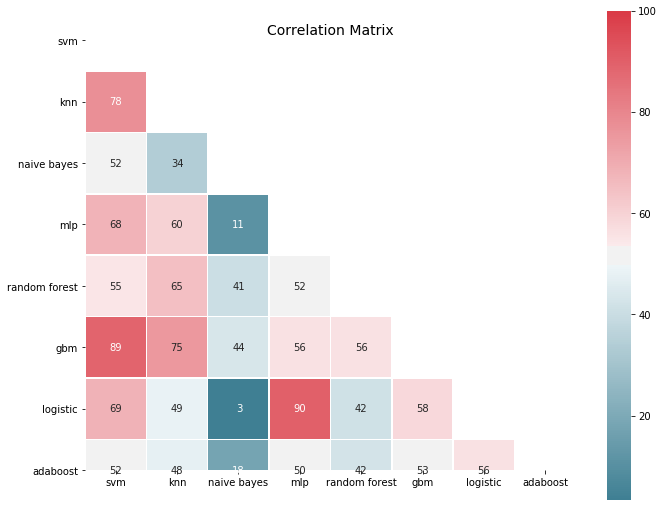

In [6]:
from matplotlib import pyplot as plt
from mlens.visualization import corrmat
corrmat(P.corr())
plt.show()

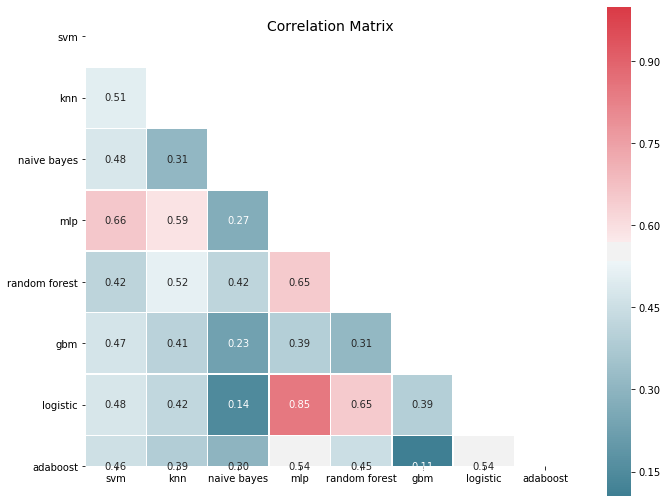

In [7]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - y_test).corr(), inflate=False)
plt.show()

In [8]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))
print("Ensemble ACC score: %.3f" % accuracy_score(y_test, np.float32(P.mean(axis=1) > 0.5)))

Ensemble ROC-AUC score: 0.903
Ensemble ACC score: 0.808


In [9]:
def plot_roc_curve(y_test, P_base_learners, P_ensemble, labels, ens_label):
    plt.plot([0, 1], [0, 1], 'k--')
    cm = [plt.cm.rainbow(i) for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])
        
    fpr, tpr, _ = roc_curve(y_test, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

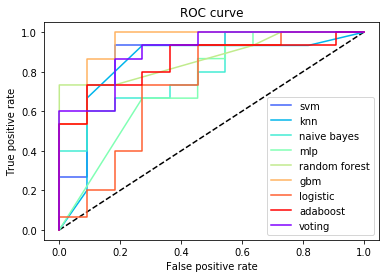

In [11]:
plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), 'voting')

In [12]:
base_learners = get_models()

In [13]:
meta_learner = GradientBoostingClassifier(
   n_estimators=1000,
   loss="exponential",
   max_features=4,
   max_depth=3,
   subsample=0.5,
   learning_rate=0.005, 
   random_state=seed
)

In [14]:
def train_base_learners(base_learners, x_train, y_train):
    print('Fitting models')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        m.fit(x_train, y_train)
    print('done.')

In [15]:
train_base_learners(base_learners, x_train, y_train)

Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
def predict_base_learners(base_learners, x):
    P = np.zeros((x.shape[0], len(base_learners)))
    print('Generating base learner predictions.')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        p = m.predict_proba(x)
        P[:, i] = p[:, 1]
    print('done.')
    return P

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.


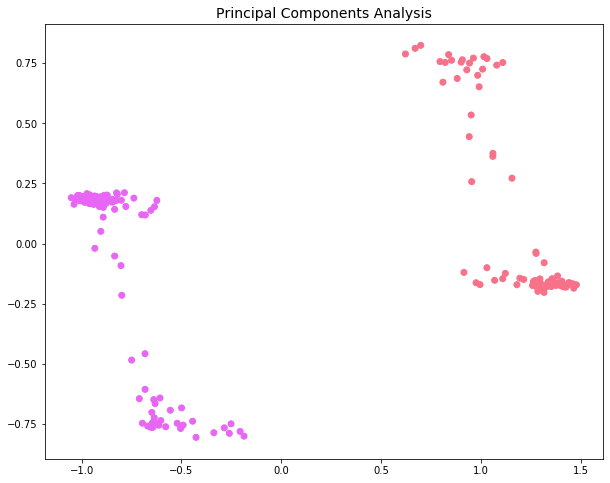

In [24]:
P_base = predict_base_learners(base_learners, x_train)
pca_plot(P_base, PCA(n_components=2), y=y_train)

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.


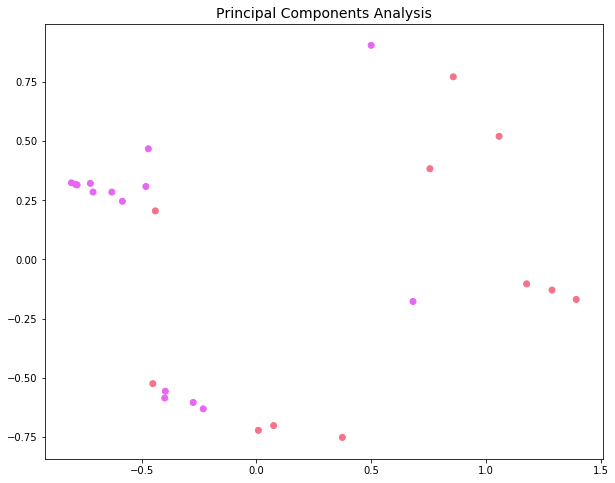

In [20]:
P_test = predict_base_learners(base_learners, x_test)
pca_plot(P_test, PCA(n_components=2), y=y_test)

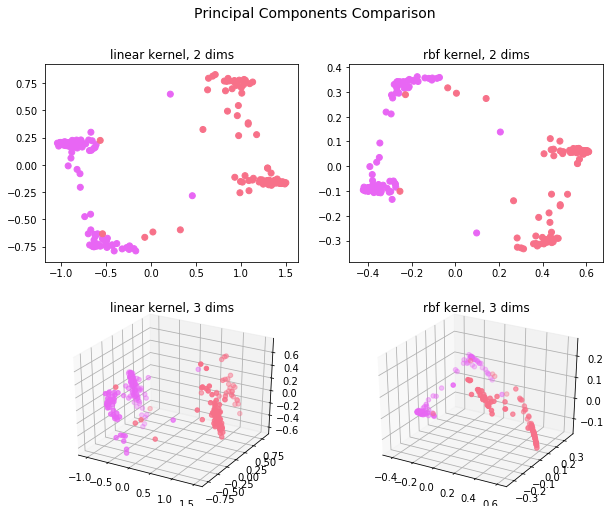

In [23]:
from mlens.visualization import pca_comp_plot
pca_comp_plot(P_base, y_train)
plt.show()

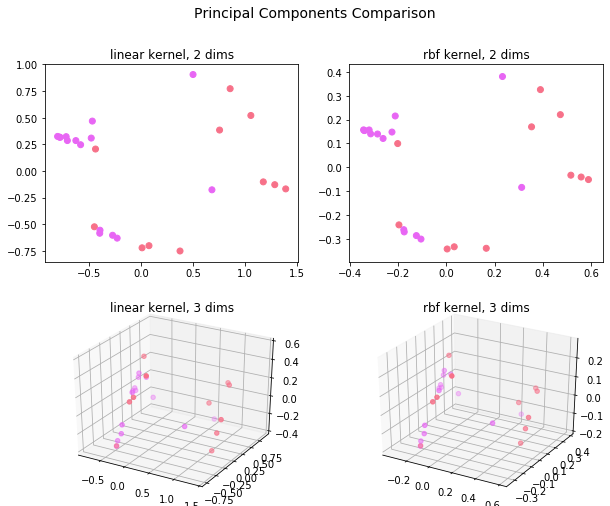

In [21]:
pca_comp_plot(P_test, y_test)
plt.show()

In [25]:
meta_learner.fit(P_base, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='exponential', max_depth=3,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=2019, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [26]:
def ensemble_predict(base_learners, meta_learner, x):
    P_pred = predict_base_learners(base_learners, x)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

In [27]:
P_pred, p = ensemble_predict(base_learners, meta_learner, x_test)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
print("Ensemble ACC score: %.3f" % accuracy_score(y_test, np.float32(p > 0.5)))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.933
Ensemble ACC score: 0.808


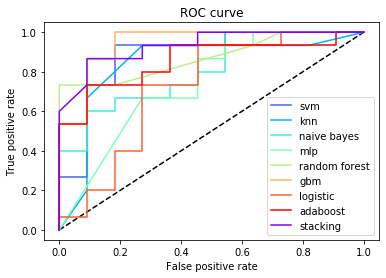

In [29]:
plot_roc_curve(y_test, P.values, p, list(P.columns), 'stacking')

In [30]:
from sklearn.base import clone

In [31]:
def stacking(base_learners, meta_learner, X, y, generator):
    print('Fitting base learners...', end='')
    train_base_learners(base_learners, X, y)
    print('done.')
    
    print('Generating cross-validated predctions...')
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):
        fold_x_train, fold_y_train = X[train_idx, :], y[train_idx]
        fold_x_test, fold_y_test = X[test_idx, :], y[test_idx]
        fold_base_learners = {name: clone(model) for name, model in base_learners.items()}
        train_base_learners(fold_base_learners, fold_x_train, fold_y_train)
        fold_P_base = predict_base_learners(fold_base_learners, fold_x_test)
        cv_preds.append(fold_P_base)
        cv_y.append(fold_y_test)
        print('Fold %i done' %i)
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)
    
    print('Fitting meta learner...', end='')
    meta_learner.fit(cv_preds, cv_y)
    print('done')
    return base_learners, meta_learner

def cross_val_stacking(base_learners, meta_learner, X, y, generator):
    cv_scores = []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):
        fold_x_train, fold_y_train = X[train_idx, :], y[train_idx]
        fold_x_test, fold_y_test = X[test_idx, :], y[test_idx]
        cv_base_learners, cv_meta_learner = stacking(get_models(), clone(meta_learner), fold_x_train, fold_y_train, generator)
        _, p = ensemble_predict(cv_base_learners, cv_meta_learner, fold_x_test)
        acc = accuracy_score(fold_y_test, np.float32(p > 0.5))
        cv_scores.append(acc)
    return cv_scores

In [32]:
from sklearn.model_selection import KFold
cv_base_learners, cv_meta_learner = stacking(get_models(), clone(meta_learner), x_train, y_train, KFold(10))

Fitting base learners...Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
done.
Generating cross-validated predctions...


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Fold 0 done
Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Fold 1 done


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Generating base learner predictions.
svm...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Fold 2 done
Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Fold 3 done


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Fold 4 done
Fitting models
svm...knn...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Generating base learner predictions.

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Fold 5 done
Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Fold 6 done


C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logistic...adaboost...done.
Fold 7 done
Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


adaboost...done.
Fold 8 done
Fitting models
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.
Fold 9 done
Fitting meta learner...

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done


In [33]:
P_pred, p = ensemble_predict(base_learners, meta_learner, x_test)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
print("Ensemble ACC score: %.3f" % accuracy_score(y_test, np.float32(p > 0.5)))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, x_test)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
print("Ensemble ACC score: %.3f" % accuracy_score(y_test, np.float32(p > 0.5)))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.933
Ensemble ACC score: 0.808
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gbm...logistic...adaboost...done.

Ensemble ROC-AUC score: 0.964
Ensemble ACC score: 0.923


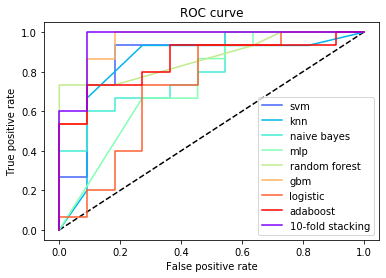

In [34]:
plot_roc_curve(y_test, P.values, p, list(P.columns), '10-fold stacking')